In [ ]:
import pandas as pd
import ast, json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import csv
import nltk

Ler json válido

In [2]:
with open('databases/json/json_fixed.json', encoding='utf-8') as valid_json:

    data = json.loads(valid_json.read())


Configurando o Pandas para nao ter limite de saída nos prints

In [3]:
pd.set_option('display.max_rows', None)

Processando os dados com pandas

In [4]:
df = pd.json_normalize(data)

Lendo CSV de referencia

In [68]:
# r_df = pd.read_csv('databases/reference/teste.xlsx',
#                    on_bad_lines='skip',
#                    encoding='utf-8',
#                    quoting=csv.QUOTE_NONE,
#                    engine='python',
#                    sep=';')
r_df = pd.read_excel('databases/reference/teste.xlsx')

Definindo somente duas colunas para trabalho

In [70]:
pre_proc_r_df = r_df[['Log Level','Log Name', 'Message', 'Possible Causes']]

Limpando os dados para que possamos ter somente os levels e name

In [7]:
pre_proc_r_df = pre_proc_r_df[pre_proc_r_df['Log Level'].fillna('').str.strip().str.isdigit()]

Filtrando apenas log level maior que 4

In [8]:
pre_proc_r_df['level'] = pd.to_numeric(pre_proc_r_df['Log Level'], errors='coerce')
filtered_pre_proc_r_df = pre_proc_r_df[pre_proc_r_df['level'] > 5]
print(filtered_pre_proc_r_df)

      Log Level                               Log Name  level
185           6                   SSHS_STARTWORK_ERROR      6
474           6                        ERR_VER_PKT_MLD      6
871           6                 LDP_SOURCE_TRACE_EVENT      6
1205          6                         ALLOC_FREE_RES      6
1249          6                     RUNNING_CFG_CHANGE      6
1409          6                            BSR_CNT_LMT      6
1497          6                        HWChannelNormal      6
2144          6                            NOTIFY_RECV      6
2306          6                            RCV_SSP_MSG      6
2391          6              CFG_DELETE_FILEWITHCKPDIR      6
2735          6                         TIMEUPDATE_CRL      6
2749          6                  hwOFPFlowCtrlLongTime      6
2909          6                    CSPF_LS_NODE_STALED      6
2994          6                          RIPNG_NBR_ADD      6
3125          6         ISIS_SRGB_CONFLICT_IGNORE_INFO      6
3301    

Criando uma lista de termos à serem desconsiderados na analise

In [9]:
termos_irrelevantes = []

for name in filtered_pre_proc_r_df['Log Name']:
    termos_irrelevantes.append(name)

regex_para_termos_irrelevantes = '|'.join(termos_irrelevantes)

df = df[~df['event_type'].str.contains(regex_para_termos_irrelevantes, na=False, case=False)]

Event type interessantes

In [10]:
int_event_type = ["LOGIN", "LOGOUT", "SSH", "IM_LOGFILE_AGING_DELETE", "IP_UNLOCKED"]
regex_int_event_type = '|'.join(int_event_type)

Aplicando ffiltro de termos interessantes

In [11]:
df = df[df['event_type'].str.contains(regex_int_event_type, na=False, case=False)]

Equipamentos envolvidos

In [12]:
equitos_envolvidos = ["WAN-RJ-CIR-02", "WAN-RJ-CIR-01"]

Filtrando por equipamentos

In [13]:
df = df[df['hostname'].isin(equitos_envolvidos)]

Contando os dados por event_type

In [14]:
logs_por_tempo = df.dropna(subset=['@timestamp'])
valores_por_event_type = df['event_type'].value_counts()
print(f"Valores por Event type: {valores_por_event_type}\n")

Valores por Event type: event_type
OPS_LOGIN                   239
OPS_LOGOUT                  239
SSHS_REKEY_STATUS            98
SSH_USER_LOGIN_FAIL          50
LOGIN                        34
SSH_USER_LOGIN               34
LOGOUT                       31
SSH_USER_LOGOUT              31
SSH_USER_LOGIN_FAIL_SCHD     21
IM_LOGFILE_AGING_DELETE      10
IP_UNLOCKED                   2
SSHS_IP_BLOCK_CLIENT          1
Name: count, dtype: int64



Contando os logs por timestamp

In [16]:
valores_por_timestamp = df['@timestamp'].value_counts()

Moda dos logs

In [ ]:
moda_logs = valores_por_timestamp.mode()[0]

Filtrando apenas os timestamps com valor maior que a moda

In [ ]:
timestamps_filtrados = valores_por_timestamp[valores_por_timestamp > moda_logs].index

Aplicando o filtro

In [ ]:
logs_por_tempo = logs_por_tempo[logs_por_tempo['@timestamp'].isin(timestamps_filtrados)]

Plotando gráfico de ocorrencias por timestamp

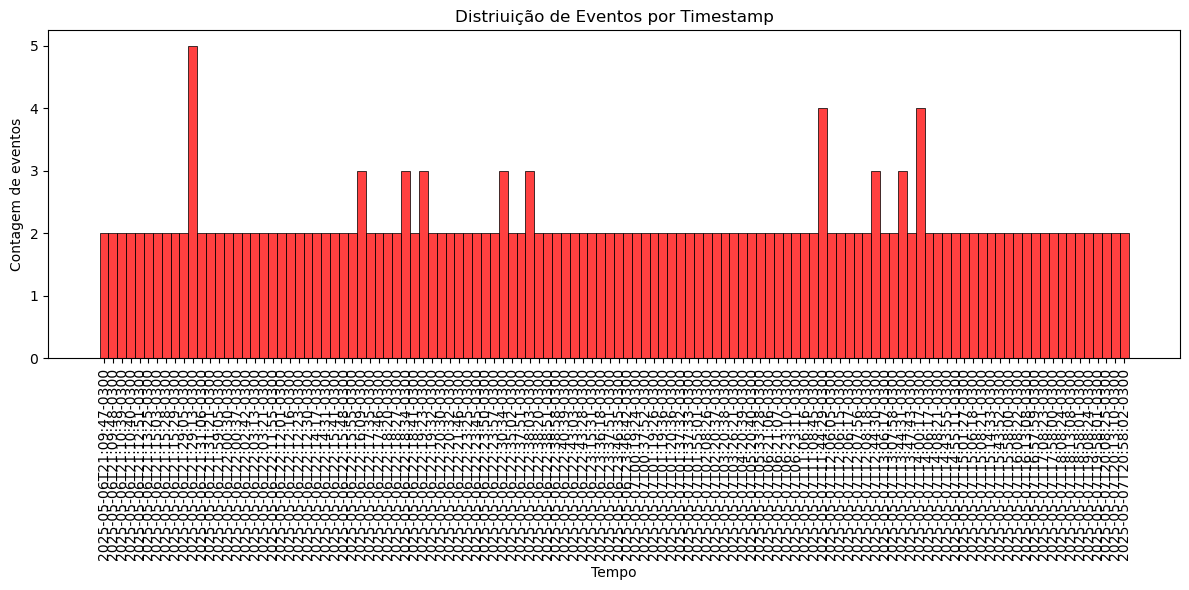

In [20]:
plt.figure(figsize=(12,6))
sns.histplot(logs_por_tempo['@timestamp'], bins=50, kde=False, color='red')

plt.title('Distriuição de Eventos por Timestamp')
plt.xlabel('Tempo')
plt.ylabel('Contagem de eventos')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

plt.show()


Pré processando message do equipamento

In [83]:
from nltk.tokenize import word_tokenize
import nltk
import unidecode
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('punkt')

pre_proc_df = df[['hostname', 'message', 'event_type', '@timestamp']]

tokenizer = RegexpTokenizer(r'\w+')

stopwords = nltk.corpus.stopwords.words('English')
stopwords

# Passando pra minusculo e retirando pontuacoes
pre_proc_df['pre_proc_message'] = pre_proc_df['message'].apply(lambda x: x.lower())
pre_proc_df['pre_proc_message'] = pre_proc_df['pre_proc_message'].apply(lambda x: ' '.join([unidecode.unidecode(termo) for termo in x.split()]))

# Tokenizando
pre_proc_df['pre_proc_message'] = pre_proc_df['pre_proc_message'].apply(lambda x: ' '.join(tokenizer.tokenize(x)))

# Removendo stop Words
pre_proc_df['pre_proc_message'] = pre_proc_df['pre_proc_message'].apply(lambda x: ' '.join([termo for termo in x.split() if termo not in stopwords]))
pre_proc_df

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/renan.lopes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/renan.lopes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/gv/z4jx1xjd169f4p7_m7g7mb6r0000gr/T/ipykernel_97596/3777352563.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_proc_df['pre_proc_message'] = pre_proc_df['message'].apply(lambda x: x.lower())
/var/folders/gv/z4jx1xjd169f4p7_m7g7mb6r0000gr/T/ipykernel_97596/3777352563.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

,hostname,message,event_type,@timestamp,pre_proc_message
14,WAN-RJ-CIR-02,%%01OPS/5/OPS_LOGIN(s):CID=0x80b40471;Succeede...,OPS_LOGIN,2025-05-06T21:00:44-0300,01ops 5 ops_login cid 0x80b40471 succeeded est...
16,WAN-RJ-CIR-02,%%01OPS/5/OPS_LOGOUT(s):CID=0x80b40471;The OPS...,OPS_LOGOUT,2025-05-06T21:00:50-0300,01ops 5 ops_logout cid 0x80b40471 ops connecti...
71,WAN-RJ-CIR-01,%%01CLI/5/LOGIN(s):CID=0x80ca2713;The user suc...,LOGIN,2025-05-06T21:09:47-0300,01cli 5 login cid 0x80ca2713 user succeeded lo...
76,WAN-RJ-CIR-01,%%01SSH/5/SSH_USER_LOGIN(s):CID=0x80930466;The...,SSH_USER_LOGIN,2025-05-06T21:09:47-0300,01ssh 5 ssh_user_login cid 0x80930466 ssh user...
82,WAN-RJ-CIR-01,%%01CLI/5/LOGOUT(s):CID=0x80ca2713;The user su...,LOGOUT,2025-05-06T21:09:48-0300,01cli 5 logout cid 0x80ca2713 user succeeded l...
83,WAN-RJ-CIR-01,%%01SSH/5/SSH_USER_LOGOUT(s):CID=0x80930466;Th...,SSH_USER_LOGOUT,2025-05-06T21:09:48-0300,01ssh 5 ssh_user_logout cid 0x80930466 ssh use...
94,WAN-RJ-CIR-01,%%01CLI/5/LOGIN(s):CID=0x80ca2713;The user suc...,LOGIN,2025-05-06T21:10:39-0300,01cli 5 login cid 0x80ca2713 user succeeded lo...
97,WAN-RJ-CIR-01,%%01SSH/5/SSH_USER_LOGIN(s):CID=0x80930466;The...,SSH_USER_LOGIN,2025-05-06T21:10:39-0300,01ssh 5 ssh_user_login cid 0x80930466 ssh user...
100,WAN-RJ-CIR-02,%%01CLI/5/LOGIN(s):CID=0x80ca2713;The user suc...,LOGIN,2025-05-06T21:10:40-0300,01cli 5 login cid 0x80ca2713 user succeeded lo...
102,WAN-RJ-CIR-02,%%01SSH/5/SSH_USER_LOGIN(s):CID=0x80930466;The...,SSH_USER_LOGIN,2025-05-06T21:10:40-0300,01ssh 5 ssh_user_login cid 0x80930466 ssh user...


Pré-processar o arquivo de referencia

In [82]:
from nltk.tokenize import word_tokenize
import nltk
import unidecode
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('punkt')

# Normalizando texto de possíveis causas
pre_proc_r_df['pre_proc_causes'] = pre_proc_r_df['Possible Causes'].apply(lambda x: str(x).lower())


# Retirando pontuaçoes
pre_proc_r_df['pre_proc_causes'] = pre_proc_r_df['pre_proc_causes'].apply(lambda x: ' '.join([unidecode.unidecode(termo) for termo in x.split()]))

# Retirando o termo 'possible causes' que está presente repetidamente em todas as linhas
pre_proc_r_df['pre_proc_causes'] = pre_proc_r_df['pre_proc_causes'].str.replace('possible causes', '', case=False)

# Tokenizando
pre_proc_r_df['pre_proc_causes'] = pre_proc_r_df['pre_proc_causes'].apply(lambda x: ' '.join(tokenizer.tokenize(x)))

# Removendo stopwords
pre_proc_r_df['pre_proc_causes'] = pre_proc_r_df['pre_proc_causes'].apply(lambda x: ' '.join([termo for termo in x.split() if termo not in stopwords]))

pre_proc_r_df

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/renan.lopes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/renan.lopes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/gv/z4jx1xjd169f4p7_m7g7mb6r0000gr/T/ipykernel_97596/2018977317.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_proc_r_df['pre_proc_causes'] = pre_proc_r_df['Possible Causes'].apply(lambda x: str(x).lower())
/var/folders/gv/z4jx1xjd169f4p7_m7g7mb6r0000gr/T/ipykernel_97596/2018977317.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,Log Level,Log Name,Message,Possible Causes,pre_proc_causes
0,1,hwEntityInvalid_active-67619,DEVM/1/hwEntityInvalid_active: Physical entity...,Possible Causes\nThe input voltage of a power ...,input voltage power module fell lower threshold
1,1,hwBoardFail_active-132191,DEVM/1/hwBoardFail_active: The board partially...,Possible Causes\nThe slave MPU reset signal of...,slave mpu reset signal board abnormal
2,3,OSPFV3_TRAP_IF_RX_BAD_PKT,OSPFV3/3/OSPFV3_TRAP_IF_RX_BAD_PKT: An OSPFV3 ...,Possible Causes\nAn incorrect packet that was ...,incorrect packet sent peer non virtual interfa...
3,4,STATISTIC_clear,EOAM-Y1731/4/STATISTIC_clear: The Y.1731 stati...,Possible Causes\nThe Y.1731 performance statis...,1731 performance statistic value fell alarm cl...
4,2,hwBierPrefixBfridConflict_clear,BIER/2/hwBierPrefixBfridConflict_clear: The [C...,Possible Causes\nConfiguration is changed.\n,configuration changed
5,4,hwEthernetARPThresholdExceedAlarm_clear,ARP/4/hwEthernetARPThresholdExceedAlarm_clear:...,Possible Causes\nThe number of ARP entries on ...,number arp entries device fell upper threshold
6,4,ASPATH_OVR_LMT,BGP/4/ASPATH_OVR_LMT: The count of AS in AS_PA...,Possible Causes\nThe AS_Path length exceeds th...,as_path length exceeds upper limit
7,5,GET_CRL_OK,PKI/5/GET_CRL_OK: Succeeded in getting CRL ([F...,Possible Causes\nThe device was properly conne...,device properly connected server
8,1,hwEntityInvalid_clear-67634,DEVM/1/hwEntityInvalid_clear: A faulty physica...,Possible Causes\nThe alarm indicating that the...,alarm indicating i2c power module abnormal cle...
9,1,hwEntityInvalid_clear-67850,DEVM/1/hwEntityInvalid_clear: A faulty physica...,Possible Causes\nA port on the ICU is up.\n,port icu
